# FRAUDWATCH AFRICA: MOBILE MONEY FRAUD DETECTION SYSTEM

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the dataset and create dataframe

df = pd.read_excel("kenya_fraud_detection.xlsx")
df.head()

,Unnamed: 0,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,"time_of_day(morning, afternoon, evening, night)",is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime
0,0,TX100000,user_8270,Withdraw Cash,2646.35,Nakuru,Feature Phone,Telkom Kenya,individual,NaN,0,0,0,2024-06-16 21:45:13
1,1,TX100001,user_1860,Send Money,2844.69,Garissa,iOS,Safaricom,agent,NaN,0,0,0,2024-06-05 00:49:25
2,2,TX100002,user_6390,Deposit Cash,2384.46,Nyeri,Feature Phone,Telkom Kenya,agent,NaN,0,0,1,2024-06-13 15:54:02
3,3,TX100003,user_6191,Withdraw Cash,1846.01,Nairobi,iOS,Safaricom,individual,NaN,0,0,1,2024-06-10 01:05:49
4,4,TX100004,user_6734,Send Money,1017.60,Machakos,Feature Phone,Telkom Kenya,individual,NaN,0,0,0,2024-06-27 02:28:53


In [3]:
# Dataset shape

print(f"\nDataset Shape: {df.shape}")
print(f"Number of transactions: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")


Dataset Shape: (10000, 14)
Number of transactions: 10,000
Number of features: 14


In [4]:
# Display basic dataset overview information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Unnamed: 0                                       10000 non-null  int64         
 1   transaction_id                                   10000 non-null  object        
 2   user_id                                          10000 non-null  object        
 3   transaction_type                                 10000 non-null  object        
 4   amount                                           10000 non-null  float64       
 5   location                                         10000 non-null  object        
 6   device_type                                      10000 non-null  object        
 7   network_provider                                 10000 non-null  object        
 8   user_type                            

In [5]:
# Statistical summary

df.describe()

,Unnamed: 0,amount,"time_of_day(morning, afternoon, evening, night)",is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime
count,10000.00000,10000.000000,0.0,10000.000000,10000.000000,10000.000000,10000
mean,4999.50000,3496.408626,NaN,0.032900,0.051800,0.096100,2024-06-15 09:05:16.036300288
min,0.00000,0.030000,NaN,0.000000,0.000000,0.000000,2024-06-01 00:01:11
25%,2499.75000,994.900000,NaN,0.000000,0.000000,0.000000,2024-06-08 01:28:30.500000
50%,4999.50000,2389.835000,NaN,0.000000,0.000000,0.000000,2024-06-15 05:32:18
75%,7499.25000,4847.737500,NaN,0.000000,0.000000,0.000000,2024-06-22 16:37:30.500000
max,9999.00000,30221.300000,NaN,1.000000,1.000000,1.000000,2024-06-29 23:59:33
std,2886.89568,3507.288508,NaN,0.178384,0.221634,0.294743,NaN


In [6]:
# Checking for missing values

df.isna().sum()

Unnamed: 0                                             0
transaction_id                                         0
user_id                                                0
transaction_type                                       0
amount                                                 0
location                                               0
device_type                                            0
network_provider                                       0
user_type                                              0
time_of_day(morning, afternoon, evening, night)    10000
is_foreign_number                                      0
is_sim_recently_swapped                                0
has_multiple_accounts                                  0
datetime                                               0
dtype: int64

### - seeing that the time_of_day column is full of null values, i will use the datetime column to fill it

## **Data Cleaning**

In [7]:
def wrangle(df):
    """
    Clean the dataset
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()

    # Strip whitespace from column names
    df_clean.columns = df_clean.columns.str.strip()
    
    # Clean transaction_type: remove extra whitespace between words
    df_clean['transaction_type'] = df_clean['transaction_type'].str.strip()  # Remove leading/trailing spaces
    df_clean['transaction_type'] = df_clean['transaction_type'].str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with single space

    # Convert datetime column to proper datetime dtype
    df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])
    
    # Extract hour and derive time_of_day if missing
    df_clean['hour'] = df_clean['datetime'].dt.hour
    
    def map_time_of_day(hour):
        if 6 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'
    
    df_clean['time_of_day'] = df_clean['hour'].map(map_time_of_day)

    # Drop column
    df_clean.drop(columns=["Unnamed: 0","hour","time_of_day(morning, afternoon, evening, night)"], inplace=True)

    return df_clean

In [8]:
# Wrangle / Clean Data

df = wrangle(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           10000 non-null  object        
 1   user_id                  10000 non-null  object        
 2   transaction_type         10000 non-null  object        
 3   amount                   10000 non-null  float64       
 4   location                 10000 non-null  object        
 5   device_type              10000 non-null  object        
 6   network_provider         10000 non-null  object        
 7   user_type                10000 non-null  object        
 8   is_foreign_number        10000 non-null  int64         
 9   is_sim_recently_swapped  10000 non-null  int64         
 10  has_multiple_accounts    10000 non-null  int64         
 11  datetime                 10000 non-null  datetime64[ns]
 12  time_of_day              10000 no

In [10]:
df.head()

,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime,time_of_day
0,TX100000,user_8270,Withdraw Cash,2646.35,Nakuru,Feature Phone,Telkom Kenya,individual,0,0,0,2024-06-16 21:45:13,night
1,TX100001,user_1860,Send Money,2844.69,Garissa,iOS,Safaricom,agent,0,0,0,2024-06-05 00:49:25,night
2,TX100002,user_6390,Deposit Cash,2384.46,Nyeri,Feature Phone,Telkom Kenya,agent,0,0,1,2024-06-13 15:54:02,afternoon
3,TX100003,user_6191,Withdraw Cash,1846.01,Nairobi,iOS,Safaricom,individual,0,0,1,2024-06-10 01:05:49,night
4,TX100004,user_6734,Send Money,1017.60,Machakos,Feature Phone,Telkom Kenya,individual,0,0,0,2024-06-27 02:28:53,night


## **EXPLORATORY DATA ANALYSIS (EDA)**

### 1. Transaction Amount Distribution

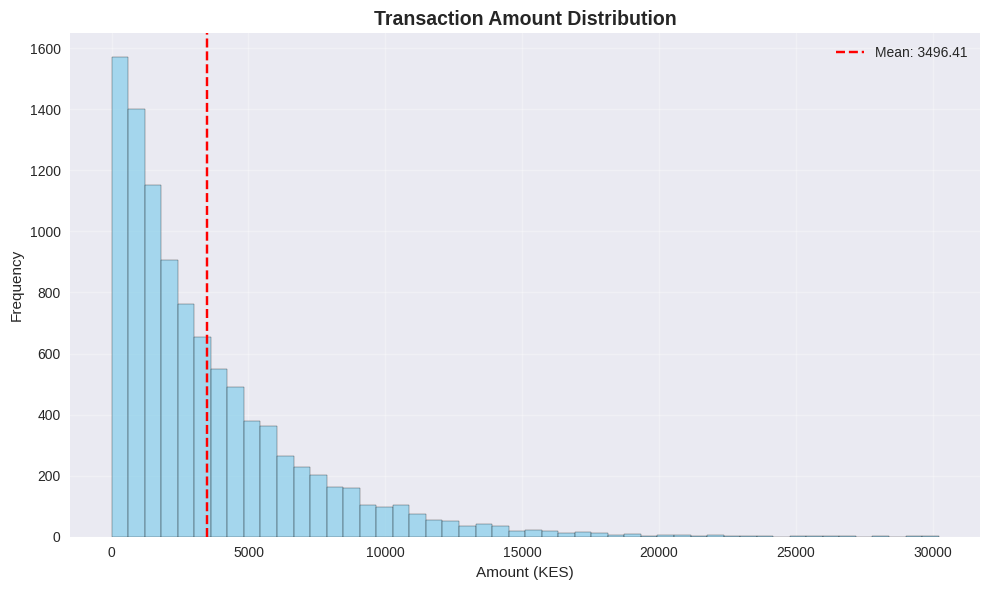

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df['amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Amount (KES)')
plt.ylabel('Frequency')
plt.axvline(df['amount'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["amount"].mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

### 2. Transaction Types Distribution

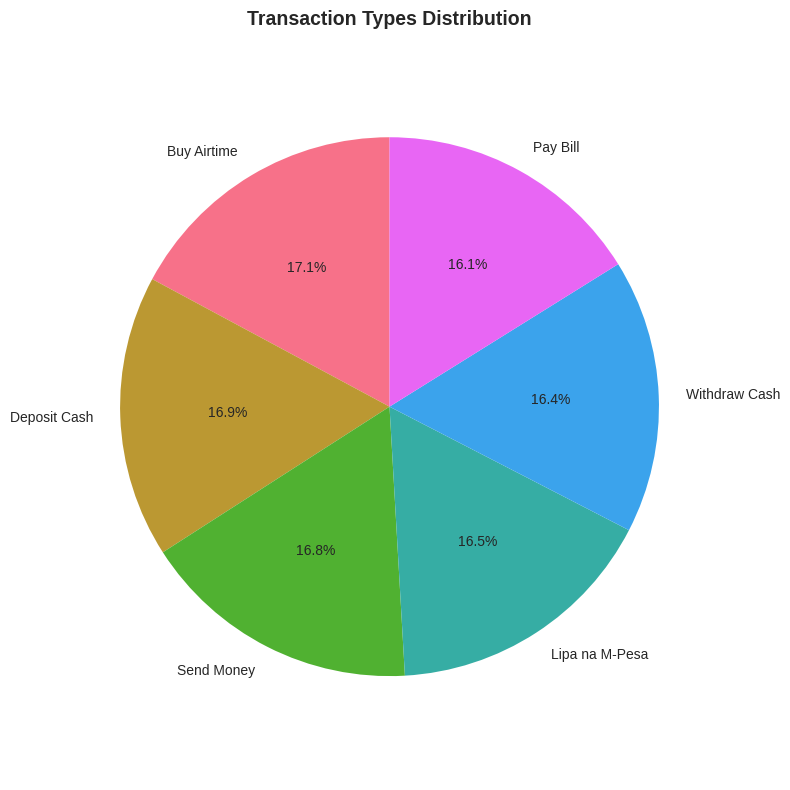

In [12]:
plt.figure(figsize=(8, 8))
transaction_counts = df['transaction_type'].value_counts()
plt.pie(transaction_counts.values, labels=transaction_counts.index, 
        autopct='%1.1f%%', startangle=90)
plt.title('Transaction Types Distribution', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show();

### 3. Geographic Distribution

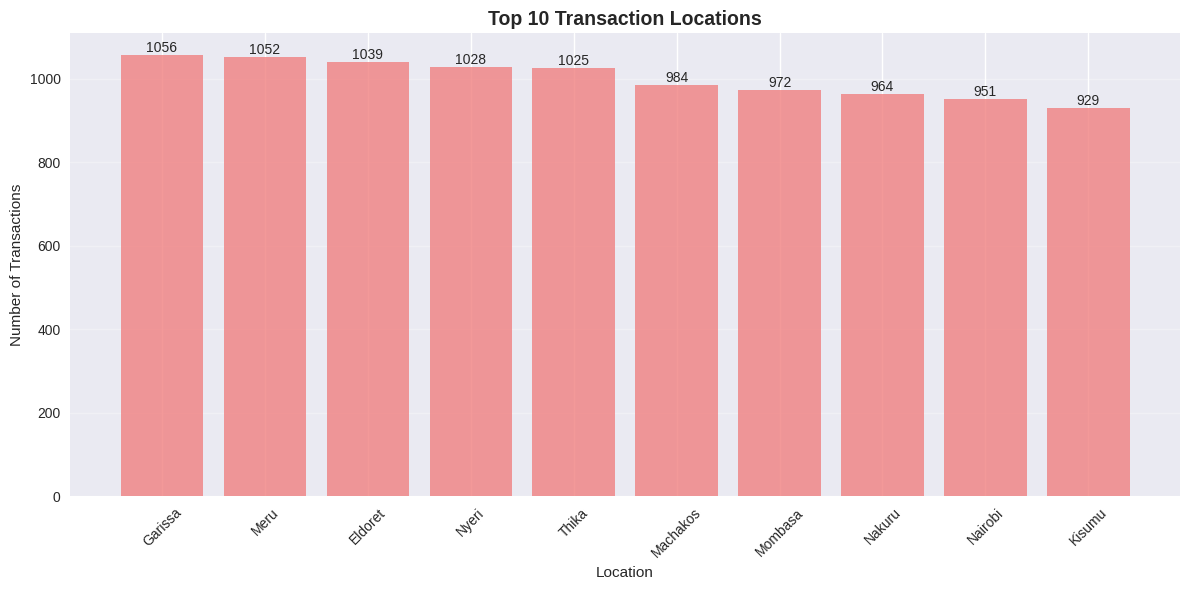

In [13]:
plt.figure(figsize=(12, 6))
location_counts = df['location'].value_counts().head(10)
bars = plt.bar(range(len(location_counts)), location_counts.values, 
               color='lightcoral', alpha=0.8)
plt.title('Top 10 Transaction Locations', fontsize=14, fontweight='bold')
plt.xticks(range(len(location_counts)), location_counts.index, rotation=45)
plt.ylabel('Number of Transactions')
plt.xlabel('Location')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show();

### 4. Device Type Distribution

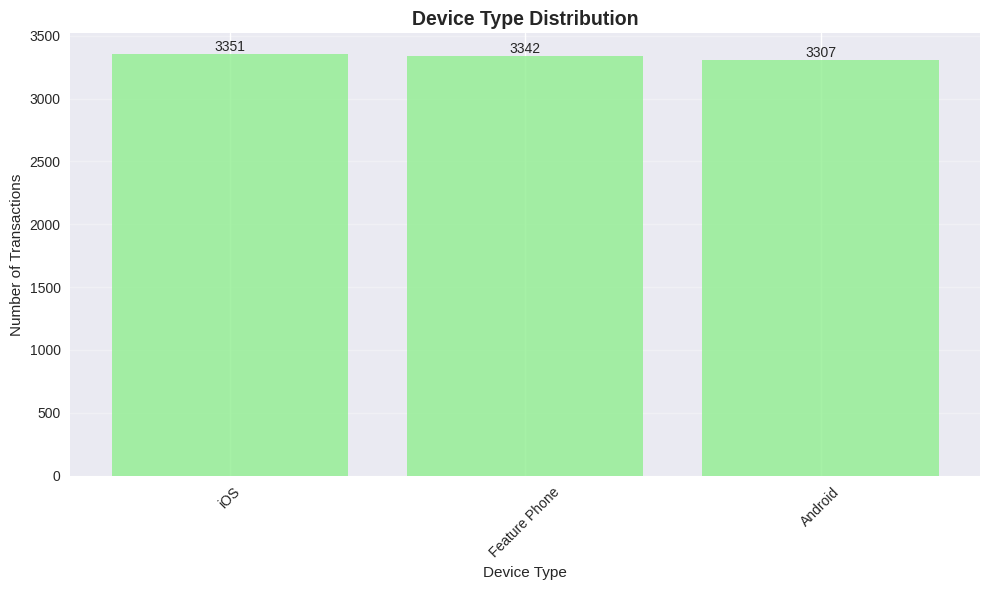

In [14]:
plt.figure(figsize=(10, 6))
device_counts = df['device_type'].value_counts()
bars = plt.bar(device_counts.index, device_counts.values, 
               color='lightgreen', alpha=0.8)
plt.title('Device Type Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Transactions')
plt.xlabel('Device Type')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show();

### 5. Network Provider Analysis

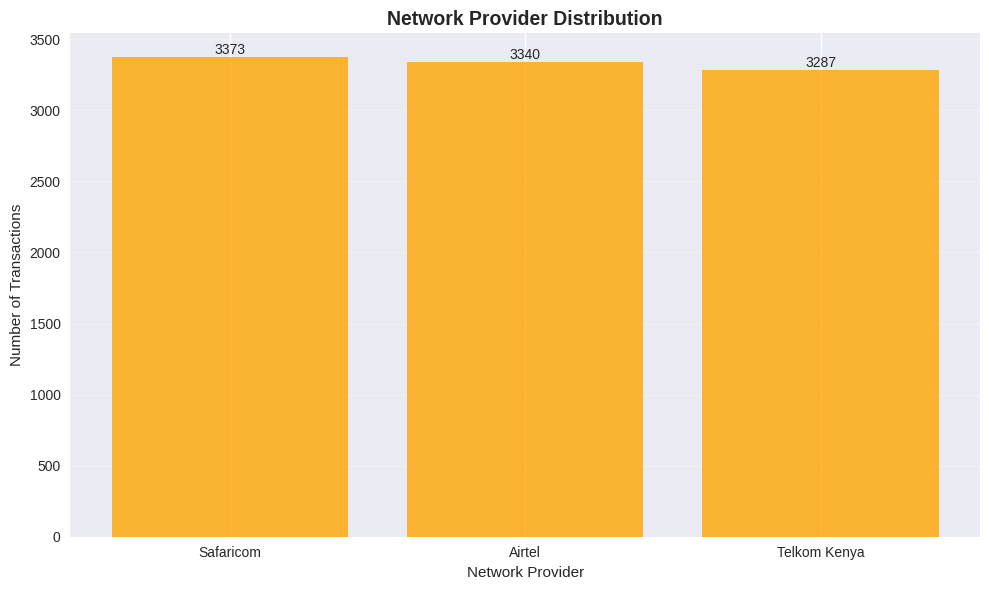

In [15]:
plt.figure(figsize=(10, 6))
network_counts = df['network_provider'].value_counts()
bars = plt.bar(network_counts.index, network_counts.values, 
               color='orange', alpha=0.8)
plt.title('Network Provider Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Transactions')
plt.xlabel('Network Provider')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 6. User Type Distribution

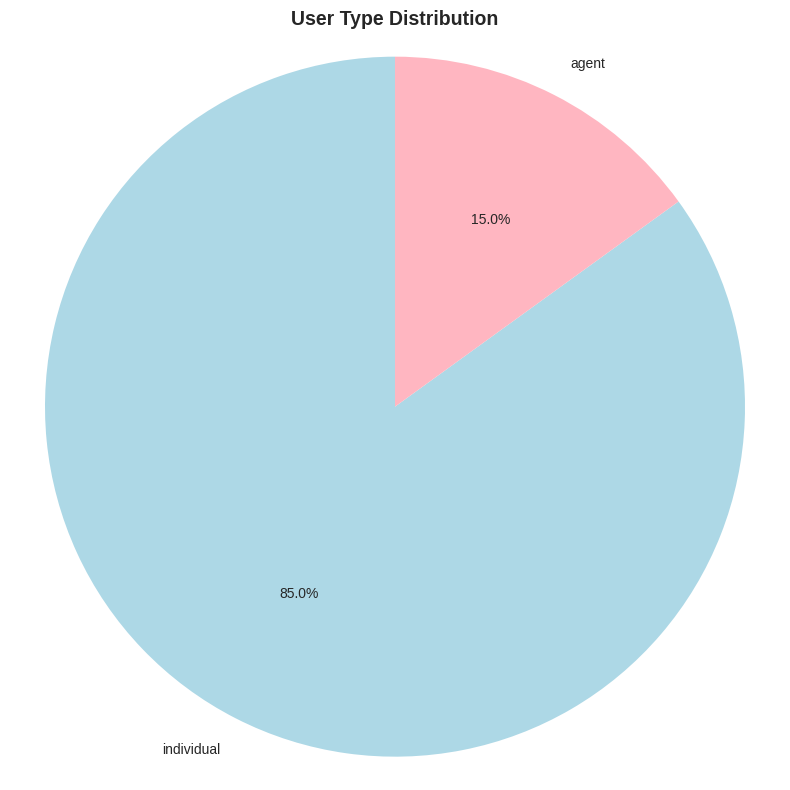

In [16]:
plt.figure(figsize=(8, 8))
user_type_counts = df['user_type'].value_counts()
plt.pie(user_type_counts.values, labels=user_type_counts.index, 
        autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink', 'lightgreen'])
plt.title('User Type Distribution', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

### 7. Risk Indicators Analysis

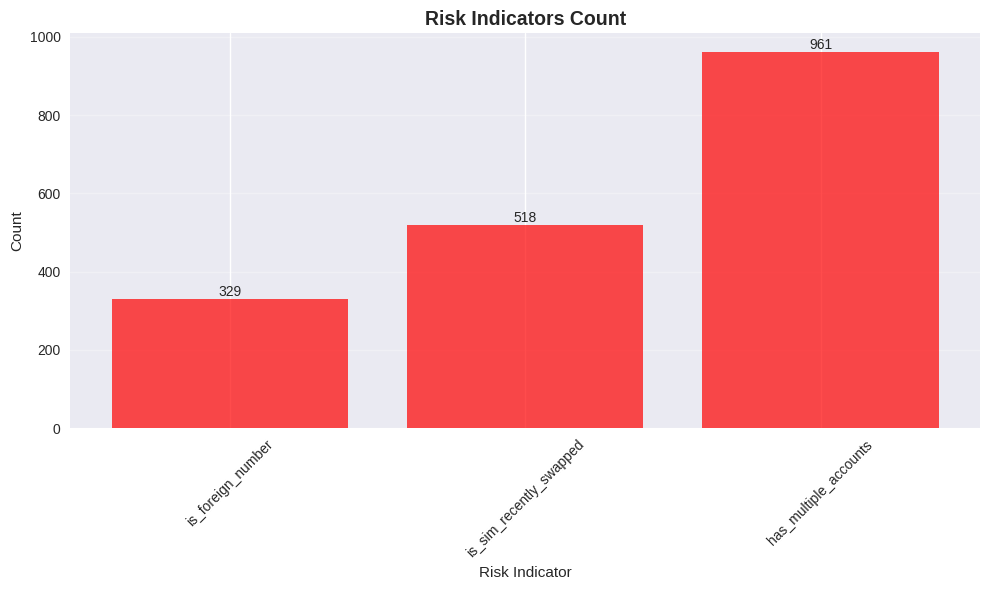

In [17]:
plt.figure(figsize=(10, 6))
risk_cols = ['is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts']
risk_data = df[risk_cols].sum()

bars = plt.bar(risk_data.index, risk_data.values, color='red', alpha=0.7)
plt.title('Risk Indicators Count', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Risk Indicator')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 8. Amount by Transaction Type

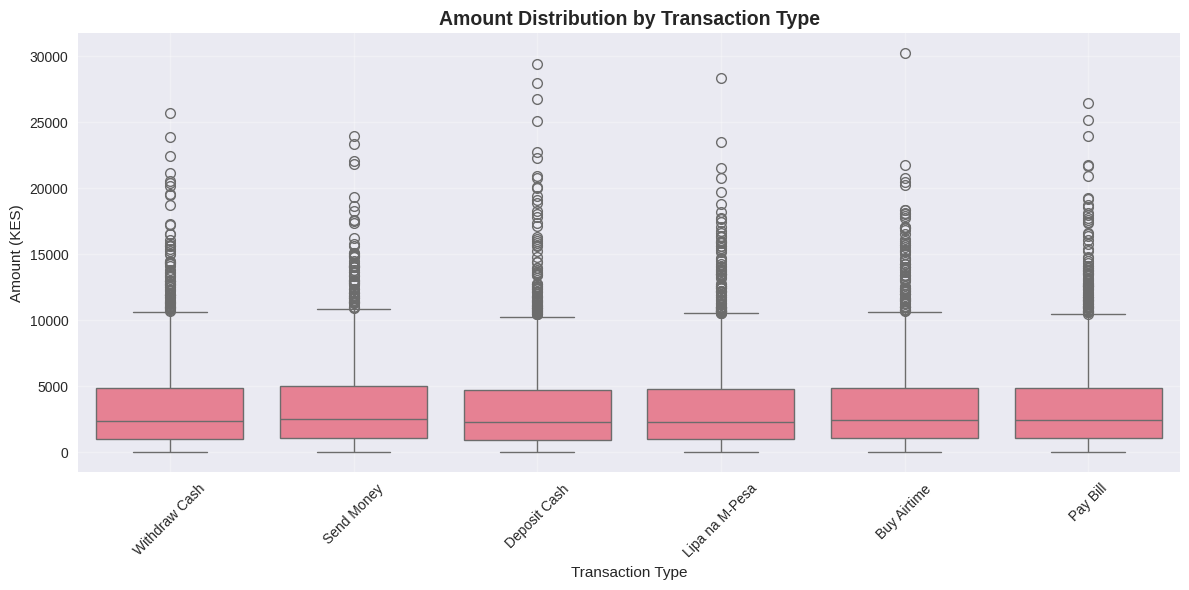

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='transaction_type', y='amount')
plt.title('Amount Distribution by Transaction Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Amount (KES)')
plt.xlabel('Transaction Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9. Feature Correlation Heatmap

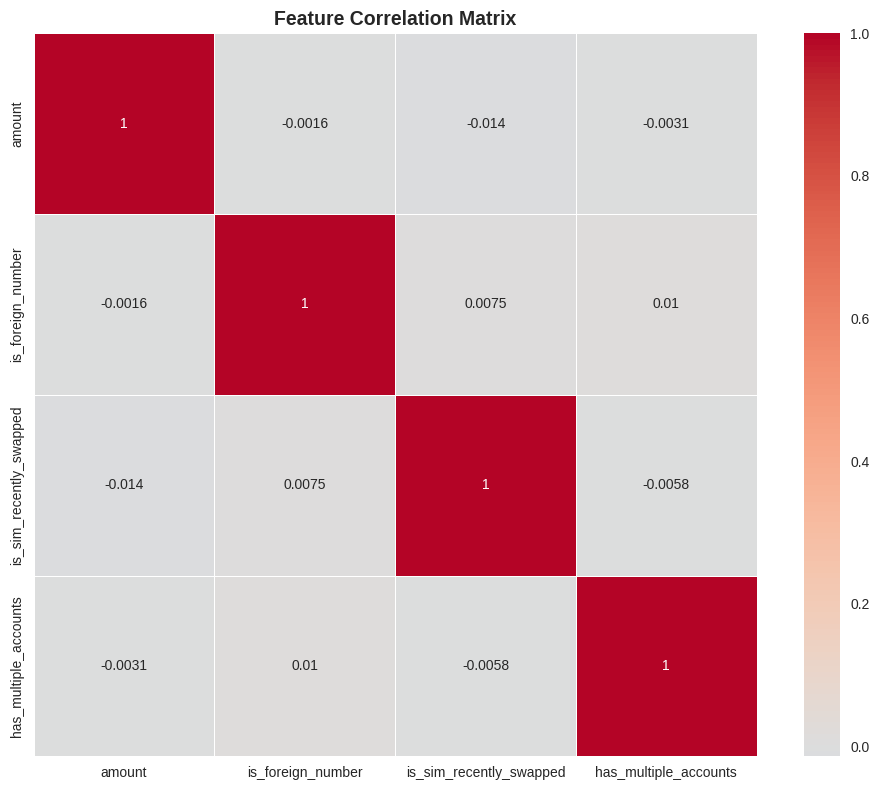

In [19]:
plt.figure(figsize=(10, 8))
numerical_cols = ['amount', 'is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts']
corr_matrix = df[numerical_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 10. Time of Day Analysis

In [20]:
time_counts = df['time_of_day'].value_counts()

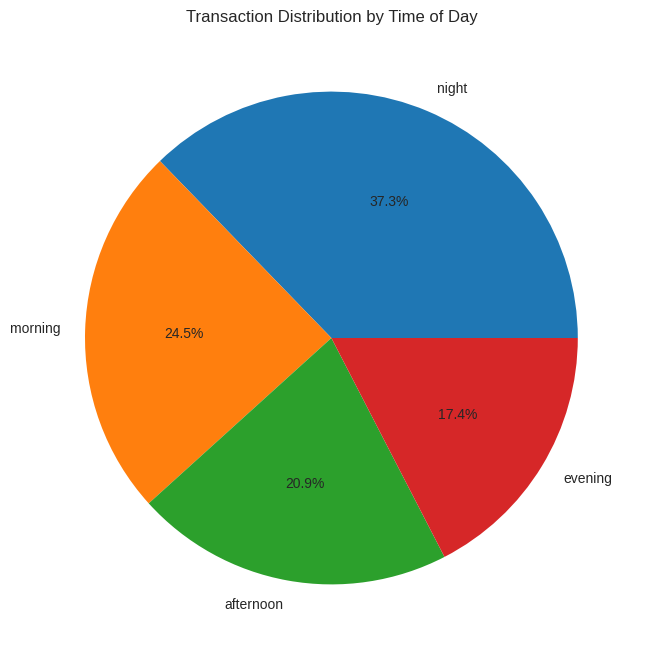

In [21]:
# 1. Time of Day Distribution (Pie Chart)

plt.figure(figsize=(12, 8))
plt.pie(time_counts.values, labels=time_counts.index, autopct='%1.1f%%', 
        colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Transaction Distribution by Time of Day')
plt.show();

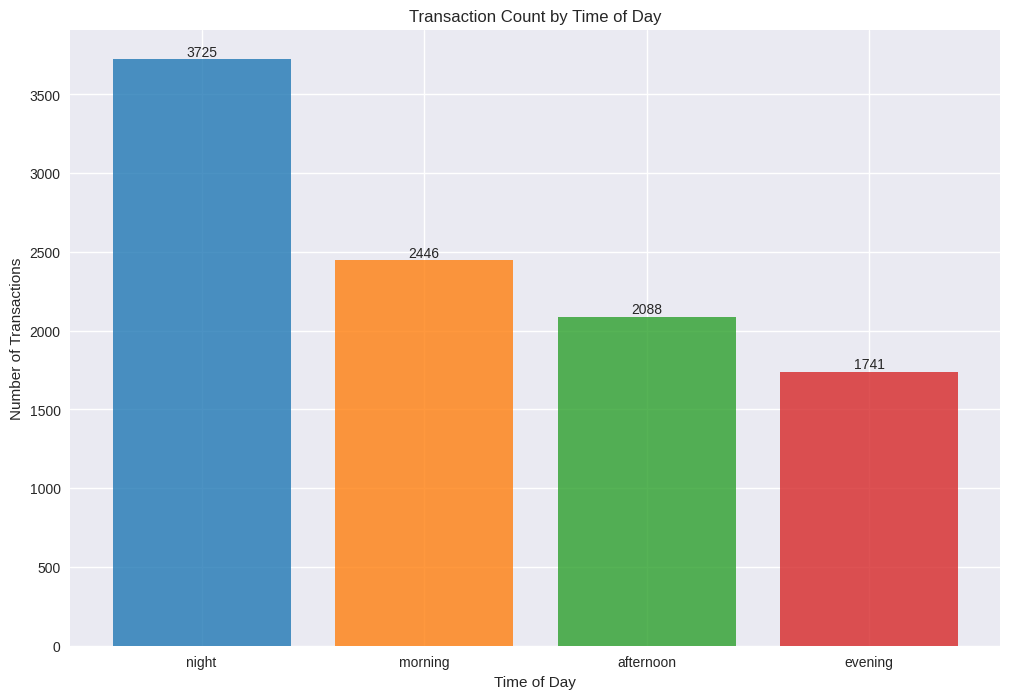

In [22]:
# 2. Time of Day Bar Chart

plt.figure(figsize=(12, 8))
bars = plt.bar(time_counts.index, time_counts.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
plt.title('Transaction Count by Time of Day')
plt.ylabel('Number of Transactions')
plt.xlabel('Time of Day')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')
plt.show()

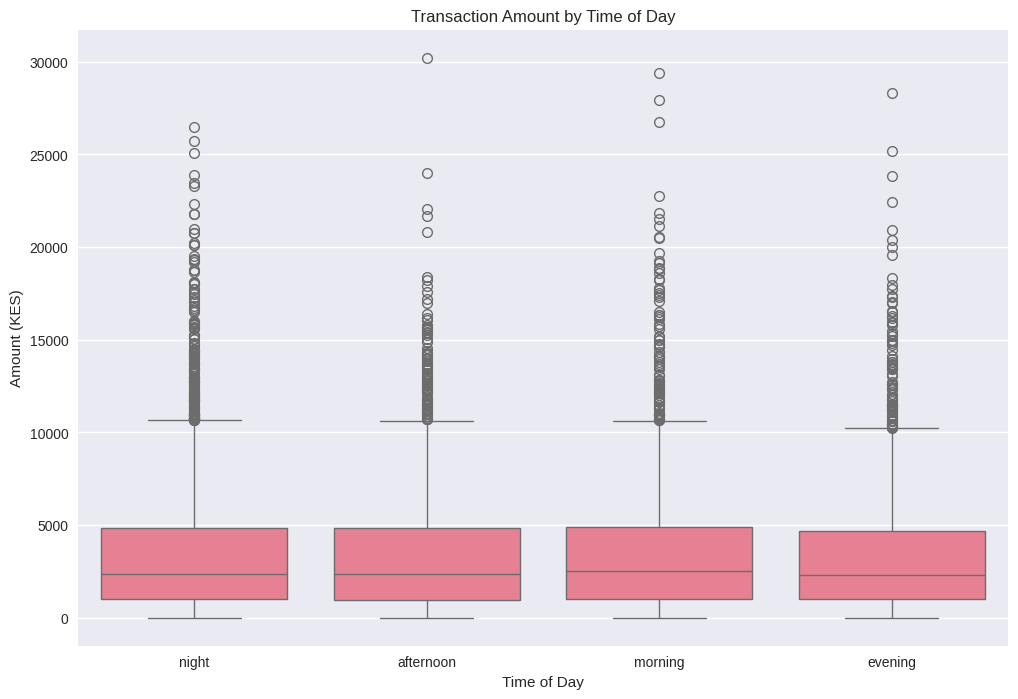

In [23]:
# 3. Amount Distribution by Time of Day (Boxplot)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='time_of_day', y='amount')
plt.title('Transaction Amount by Time of Day')
plt.ylabel('Amount (KES)')
plt.xlabel('Time of Day')
plt.show()

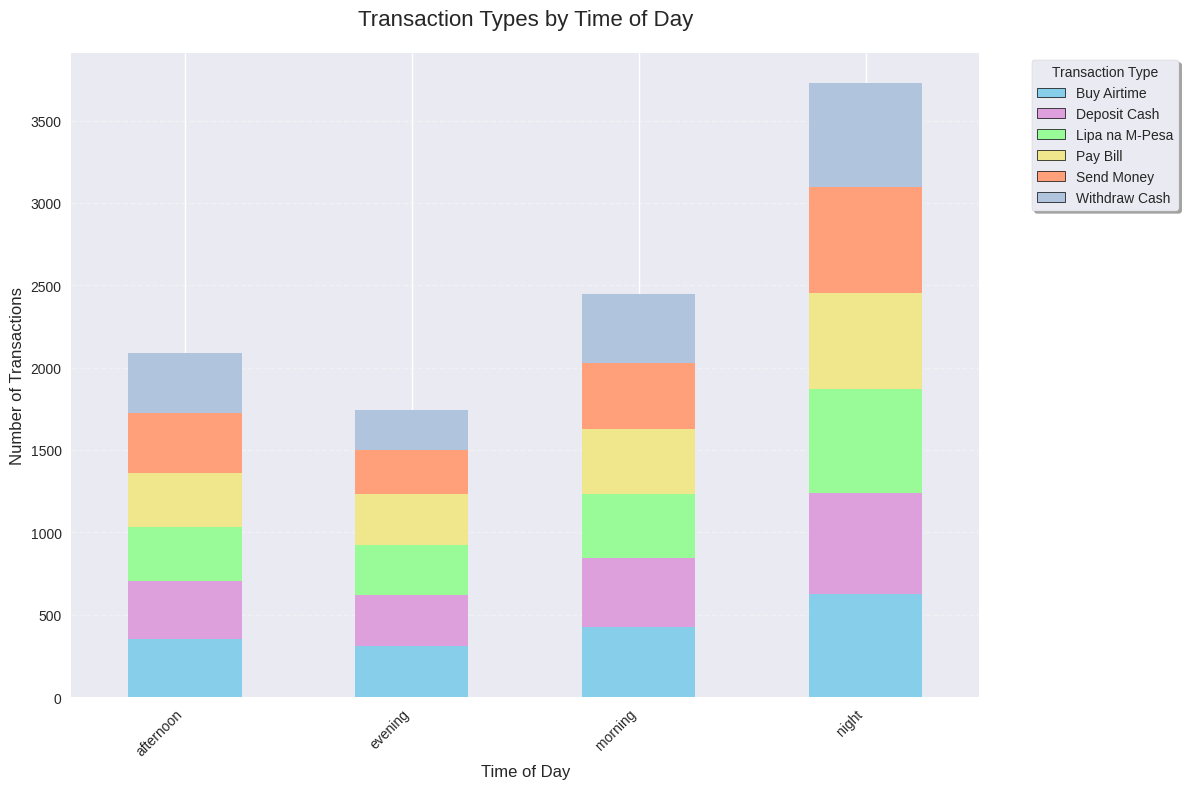

In [24]:
# 4. Transaction Types by Time of Day (Stacked Bar) 

# Create the crosstab
time_type_crosstab = pd.crosstab(df['time_of_day'], df['transaction_type'])

# Get unique transaction types
unique_transaction_types = list(time_type_crosstab.columns)

# Define a consistent color palette with meaningful colors
colors = {
    'Buy Airtime': '#87CEEB',        # Sky blue
    'Deposit Cash': '#DDA0DD',       # Plum  
    'Lipa na M-Pesa': '#98FB98',     # Pale green
    'Pay Bill': '#F0E68C',           # Khaki
    'Send Money': '#FFA07A',         # Light salmon
    'Withdraw Cash': '#B0C4DE'       # Light steel blue
}

# Create color list - use predefined colors or fallback to palette
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
color_list = []
for i, trans_type in enumerate(unique_transaction_types):
    if trans_type in colors:
        color_list.append(colors[trans_type])
    else:
        color_list.append(color_palette[i % len(color_palette)])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the stacked bar chart
time_type_crosstab.plot(kind='bar', stacked=True, color=color_list, ax=ax)

# Set title and labels
ax.set_title('Transaction Types by Time of Day', fontsize=16, pad=20)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_xlabel('Time of Day', fontsize=12)

# Remove the default legend
ax.get_legend().remove()

# Create a clean legend
legend_elements = []
for i, trans_type in enumerate(unique_transaction_types):
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color_list[i], 
                                       edgecolor='black', linewidth=0.5))

# Add the custom legend
ax.legend(legend_elements, unique_transaction_types, 
         title='Transaction Type', 
         bbox_to_anchor=(1.05, 1), 
         loc='upper left',
         frameon=True, 
         fancybox=True, 
         shadow=True)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show();

### Statistical insights

In [25]:
print(f"• Average transaction amount: KES {df['amount'].mean():,.2f}")
print(f"• Median transaction amount: KES {df['amount'].median():,.2f}")
print(f"• Transaction amount std dev: KES {df['amount'].std():,.2f}")
print(f"• 95th percentile amount: KES {df['amount'].quantile(0.95):,.2f}")

• Average transaction amount: KES 3,496.41
• Median transaction amount: KES 2,389.84
• Transaction amount std dev: KES 3,507.29
• 95th percentile amount: KES 10,559.07


In [26]:
# Risk factor analysis

risk_analysis = {
    'Foreign Numbers': df['is_foreign_number'].sum(),
    'Recent SIM Swaps': df['is_sim_recently_swapped'].sum(),
    'Multiple Accounts': df['has_multiple_accounts'].sum()
}

print(f"\n• Risk Factor Analysis:")
for factor, count in risk_analysis.items():
    percentage = (count / len(df)) * 100
    print(f"  - {factor}: {count} transactions ({percentage:.2f}%)")


• Risk Factor Analysis:
  - Foreign Numbers: 329 transactions (3.29%)
  - Recent SIM Swaps: 518 transactions (5.18%)
  - Multiple Accounts: 961 transactions (9.61%)


## **DATA PREPROCESSING**

In [27]:
# Encode categorical variables

label_encoders = {}
categorical_cols = ['transaction_type', 'location', 'device_type', 'network_provider', 'user_type', 'time_of_day']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [28]:
# Select relevant features for modeling

features = ['amount', 'transaction_type', 'location', 'device_type',
            'network_provider', 'user_type', 'time_of_day',
            'is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts']

In [29]:
X = df[features].copy()

# Scale the 'amount' feature since it has wide range

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

## **MODELLING**

### **Isolation Forest**

In [30]:
# Isolation Forest parameters
contamination_rate = 0.02  # Assume 2% of transactions are anomalous
random_state = 42

# Initialize and train Isolation Forest
iso_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=random_state,
    n_estimators=200,
    max_samples='auto',
    max_features=1.0,
    bootstrap=False,
    n_jobs=-1,
    verbose=0
)

# Fit the model
iso_forest.fit(X)

IsolationForest(contamination=0.02, n_estimators=200, n_jobs=-1,
                random_state=42)

In [31]:
# Predict anomalies

# predictions
df['anomaly_score'] = iso_forest.decision_function(X_scaled)
df['is_anomalous'] = (iso_forest.predict(X_scaled) == -1)

print(f"\nIsolation Forest flagged {df['is_anomalous'].sum()} out of {len(df)} transactions as anomalies")


Isolation Forest flagged 581 out of 10000 transactions as anomalies


### MODEL PERFORMANCE EVALUATION

### VISUALIZATION OF RESULTS

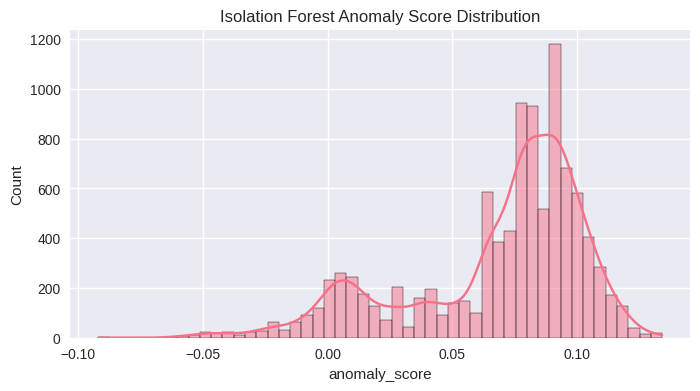

In [32]:
# Anomaly score distribution

plt.figure(figsize=(8,4))
sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.title('Isolation Forest Anomaly Score Distribution')
plt.show()

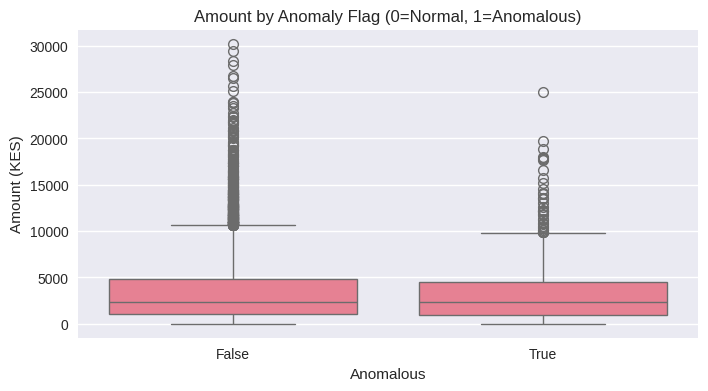

In [33]:
# Amount: normal vs anomalous

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='is_anomalous', y='amount')
plt.title('Amount by Anomaly Flag (0=Normal, 1=Anomalous)')
plt.xlabel('Anomalous')
plt.ylabel('Amount (KES)')
plt.show()

### EXPORT MODEL & ENCODERS

In [34]:
joblib.dump(iso_forest, 'isolation_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']